In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from pathlib import Path
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pynapple as nap
from spatial_manifolds.toroidal import *
from spatial_manifolds.behaviour_plots import *
from matplotlib.colors import TwoSlopeNorm
from scipy.spatial import distance
from spatial_manifolds.circular_decoder import circular_decoder, cross_validate_decoder, cross_validate_decoder_time, circular_nanmean
from spatial_manifolds.data.curation import curate_clusters
from scipy.stats import zscore
from spatial_manifolds.util import gaussian_filter_nan
from spatial_manifolds.predictive_grid import compute_travel_projected, wrap_list
from spatial_manifolds.behaviour_plots import *
from spatial_manifolds.behaviour_plots import trial_cat_priority
from spatial_manifolds.detect_grids import *

import hdbscan
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [36]:
def HDBSCAN_grid_modules(gcs, all, mouse, day, figpath='', 
                         curate_with_vr=True, curate_with_brain_region=True):
    if len(gcs) == 0:
        return [], []
    
    gcs['field_spacing'] = pd.to_numeric(gcs['field_spacing'], errors='coerce')
    gcs['orientation'] = pd.to_numeric(gcs['orientation'], errors='coerce')
    gcs.dropna(subset=['field_spacing', 'orientation'], inplace=True)

    # Extract and preprocess features
    X = gcs[["field_spacing", "orientation"]].copy()

    # Standard scale the 'field_spacing'
    scaler = StandardScaler()
    X["field_spacing_scaled"] = scaler.fit_transform(X[["field_spacing"]])

    # Cyclic encoding for 'orientation' (range 0 to 60)
    X["orientation_sin"] = np.sin(2 * np.pi * X["orientation"] / 60)
    X["orientation_cos"] = np.cos(2 * np.pi * X["orientation"] / 60)

    # Scale sine and cosine components to balance feature influence
    scale_factor = 1 / np.sqrt(2)
    X["orientation_sin_scaled"] = X["orientation_sin"] * scale_factor
    X["orientation_cos_scaled"] = X["orientation_cos"] * scale_factor

    # Prepare the feature matrix
    features = X[["field_spacing_scaled", 
                  "orientation_sin_scaled", 
                  "orientation_cos_scaled"]]

    clusterer = hdbscan.HDBSCAN(
                min_cluster_size=3,
                min_samples=1,
                cluster_selection_epsilon=0.3,
                allow_single_cluster=False,
                metric='chebyshev'
            )
    
    module_labels = clusterer.fit_predict(features)

    # Plot the results
    plt.figure(figsize=(3, 3))
    label_colors = {label: cm.get_cmap('viridis', len(np.unique(module_labels)))(i) for i, label in enumerate(np.unique(module_labels))}
    for mi in np.unique(module_labels):
        mask = module_labels == mi
        print(f'for mi{mi}, there are {np.sum(mask)} points')
        plt.scatter(np.array(X['field_spacing'])[mask], 
                    np.array(X['orientation'])[mask], c=label_colors[mi], s=20, cmap='viridis', label='Clustered Points')
    
    # Highlight unassigned points (label -1)
    plt.scatter(np.array(X['field_spacing'])[module_labels == -1], 
                np.array(X['orientation'])[module_labels == -1], s=21, color='red', label='Unassigned Points')
    plt.scatter(all['field_spacing'], all['orientation'], s=20, color='tab:grey', alpha=0.5,zorder=-1)

    #plt.legend()
    plt.xlabel('Grid spacing (cm)')
    plt.ylabel('Grid orientation ($^\circ$)')
    plt.ylim(0,60)
    plt.title(f'HDBSCAN M{mouse}D{day}')
    plt.tight_layout()
    plt.show()


    if np.unique(module_labels).size == 1 and np.unique(module_labels)[0] == -1:
        module_labels[:] = 0  # Assign all points to a single cluster if no clusters were found
        label_colors[0] = label_colors[-1]

    # put cluster ids into modules then rearange from smallest spacing to larger
    grid_module_cluster_ids = []
    grid_module_ids = []
    avg_spacings = []
    for mi, module_label in enumerate(np.unique(module_labels[module_labels != -1])):
        grid_ids = np.array(gcs['cluster_id'])
        cells = gcs[np.isin(gcs['cluster_id'], grid_ids[module_labels == module_label])]
        avg_spacings.append(np.nanmean(cells.field_spacing.values))
        grid_module_cluster_ids.append(cells['cluster_id'].tolist())
        grid_module_ids.append(mi)
        print(f'for module {mi}, there are {len(cells)} cells with average spacing {np.nanmean(cells.field_spacing.values)}')
    grid_module_cluster_ids = [x for _, x in sorted(zip(avg_spacings, grid_module_cluster_ids))]
    grid_module_ids = [x for _, x in sorted(zip(avg_spacings, grid_module_ids))]

    # now curate the modules based on the VR data and anatomy
    _,_,autocorrs,_,_,clusters_VR = compute_vr_tcs(mouse, day)
    if curate_with_brain_region:
        for mi, module_ids in zip(grid_module_ids, grid_module_cluster_ids):
            print(f'module {mi} contains cells from {np.unique(clusters_VR[module_ids].brain_region)}')
            new_module_ids = module_ids.copy()
            for id in module_ids:
                br = clusters_VR.brain_region[id]
                if br in disqualifying_brain_areas_for_grid_cells:
                    module_ids.remove(id)
            grid_module_cluster_ids[grid_module_ids.index(mi)] = new_module_ids

    if curate_with_vr:
        tolerance = 30
        # before performing the median peak check, plot the histogram of peaks
        for mi, module_ids in zip(grid_module_ids, grid_module_cluster_ids):
            matrix = np.array(list(autocorrs.values()))
            matrix_cluster_ids = np.array(list(autocorrs.keys()))
            cluster_id_of_interest = module_ids
            matrix = matrix[np.isin(matrix_cluster_ids, cluster_id_of_interest)]
            matrix_cluster_ids = matrix_cluster_ids[np.isin(matrix_cluster_ids, cluster_id_of_interest)]
            peaks = []
            for array in matrix:
                if len(find_peaks(array)[0])>0:
                    peak = find_peaks(array)[0][0]
                else:
                    peak = np.nan
                    
                '''
                plt.plot(array, color=label_colors[mi], alpha=0.5)
                plt.axvline(peak, color=label_colors[mi], linestyle='--', alpha=0.5)
                plt.show()'''

                peaks.append(peak)
            peaks = np.array(peaks)*bs
            median_peak = np.nanmedian(peaks)
            '''
            fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(2,2), squeeze=False)
            if median_peak < 200:
                max_r = 200
            else:
                max_r = 400
            ax[0,0].hist(peaks, bins=25, range=(0, max_r), color=label_colors[mi])
            ax[0,0].axvline(median_peak-tolerance, color='grey', linestyle='--')
            ax[0,0].axvline(median_peak+tolerance, color='grey', linestyle='--')
            plt.savefig(f'{figpath}/GC_peaks_{mi}_{mouse}D{day}.pdf')
            plt.show()'''

            # now check if the peaks are within 20cm of the median peak
            # also check if the rate is really low and should be considered
            for peak, cluster_id in zip(peaks, matrix_cluster_ids):
                if not np.abs(peak-median_peak)<(tolerance): # 30cm tolerance
                    module_ids.remove(cluster_id)
                elif nap.TsGroup([clusters_VR[cluster_id]]).rates[0] < 1:
                    module_ids.remove(cluster_id)

            grid_module_cluster_ids[grid_module_ids.index(mi)] = module_ids

        # now plot the histogram of peaks again 
        for mi, module_ids in zip(grid_module_ids, grid_module_cluster_ids):
            matrix = np.array(list(autocorrs.values()))
            matrix_cluster_ids = np.array(list(autocorrs.keys()))
            cluster_id_of_interest = module_ids
            matrix = matrix[np.isin(matrix_cluster_ids, cluster_id_of_interest)]
            matrix_cluster_ids = matrix_cluster_ids[np.isin(matrix_cluster_ids, cluster_id_of_interest)]
            peaks = []
            for array in matrix:
                if len(find_peaks(array)[0])>0:
                    peak = find_peaks(array)[0][0]
                else:
                    peak = np.nan
                peaks.append(peak)
            peaks = np.array(peaks)*bs
            median_peak = np.nanmedian(peaks)

            '''
            fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(2,2), squeeze=False)
            if median_peak < 200:
                max_r = 200
            else:
                max_r = 400
            ax[0,0].hist(peaks, bins=25, range=(0, max_r), color=label_colors[mi])
            ax[0,0].axvline(median_peak-tolerance, color='grey', linestyle='--')
            ax[0,0].axvline(median_peak+tolerance, color='grey', linestyle='--')
            plt.savefig(f'{figpath}/GC_peaks_{mi}_{mouse}D{day}_post_curated.pdf')
            plt.show()
            '''

    return  grid_module_ids, grid_module_cluster_ids

In [20]:
# loop over mouse and day and collect all gcs into a dictionary if there are more than 10 gcs detected
dict_t = {}
for mouse in [20,21,22,25,26,27,28,29]:
    for day in [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25,26, 27]:
        try:
            print(f'Processing mouse {mouse}, day {day}')
            gcs, ngs, ns, sc, ngs_ns, all = cell_classification_of1(mouse, day, percentile_threshold=95)
            if len(gcs) > 5:
                dict_t[f'm{mouse}d{day}'] = pd.DataFrame(gcs[['field_spacing', 'orientation']])
        except Exception as e:
            print(f'Error processing mouse {mouse}, day {day}: {e}')
            continue 
print(f'there are {len(dict_t)} mice and days with more than 10 gcs detected')   


Processing mouse 20, day 10
Error processing mouse 20, day 10: File /Users/harryclark/Downloads/COHORT12_nwb/M20/D10/VR/sub-20_day-10_ses-VR_srt-kilosort4_clusters.npz does not exist
Processing mouse 20, day 11
Error processing mouse 20, day 11: File /Users/harryclark/Downloads/COHORT12_nwb/M20/D11/VR/sub-20_day-11_ses-VR_srt-kilosort4_clusters.npz does not exist
Processing mouse 20, day 12
Error processing mouse 20, day 12: File /Users/harryclark/Downloads/COHORT12_nwb/M20/D12/VR/sub-20_day-12_ses-VR_srt-kilosort4_clusters.npz does not exist
Processing mouse 20, day 13
Error processing mouse 20, day 13: File /Users/harryclark/Downloads/COHORT12_nwb/M20/D13/VR/sub-20_day-13_ses-VR_beh.nwb does not exist
Processing mouse 20, day 14
there are this many clusters before curation 429
last_ephys_bin 22400
last_ephys_time_bin 1831.025
20 14
there are 169 non_grid and non_spatial_cells
there are 0 grid_cells
there are 93 non grid spatial cells
there are 76 non spatial cells
there are 35 speed 

Processing m20d25 with 11 grid cells


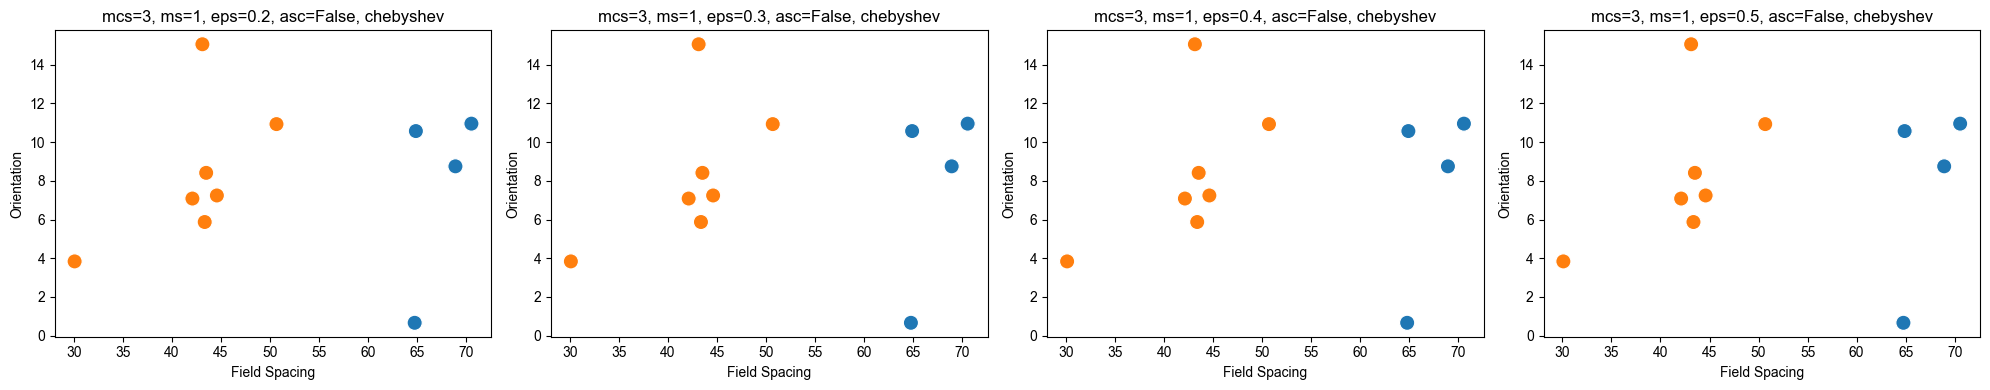

Processing m21d16 with 17 grid cells


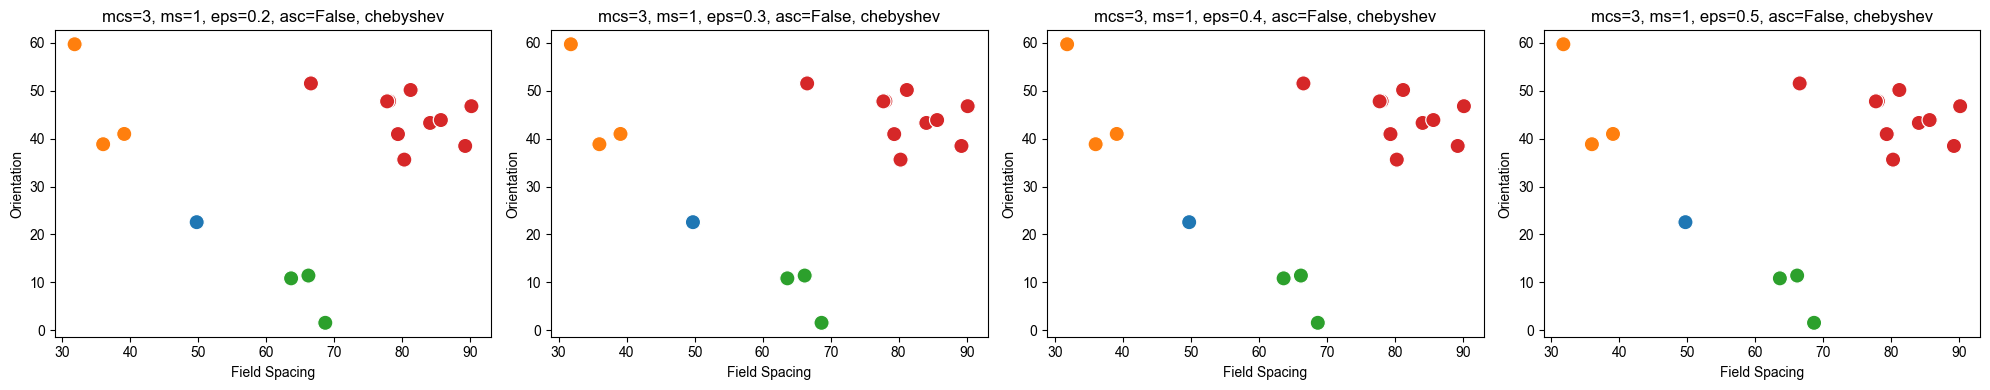

Processing m21d21 with 39 grid cells


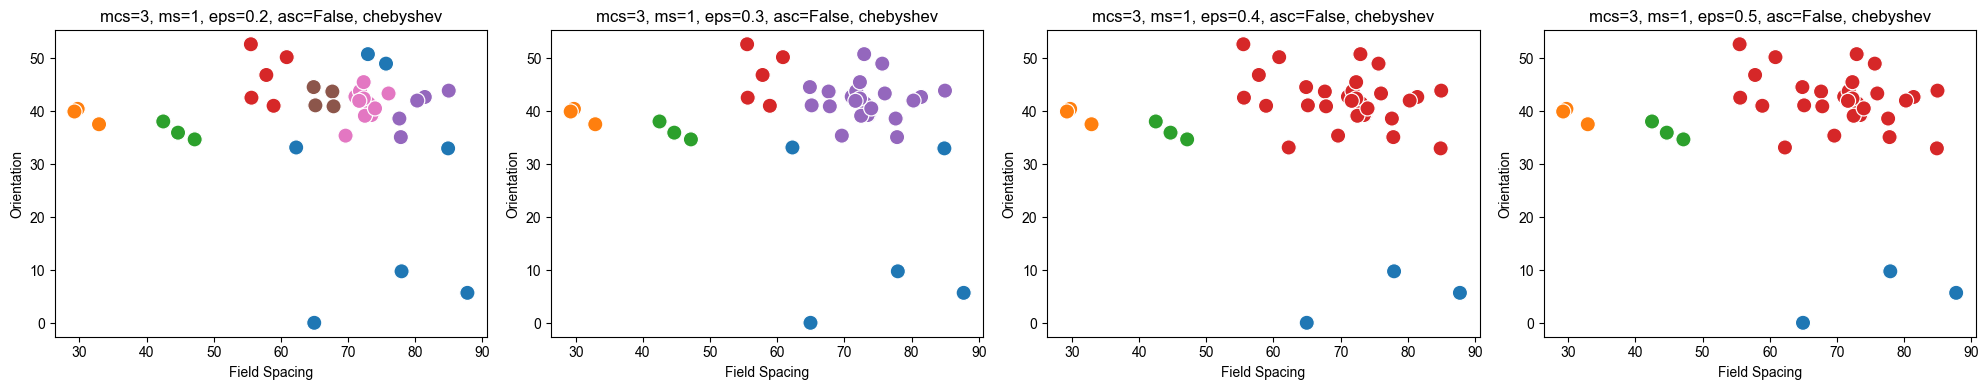

Processing m21d26 with 24 grid cells


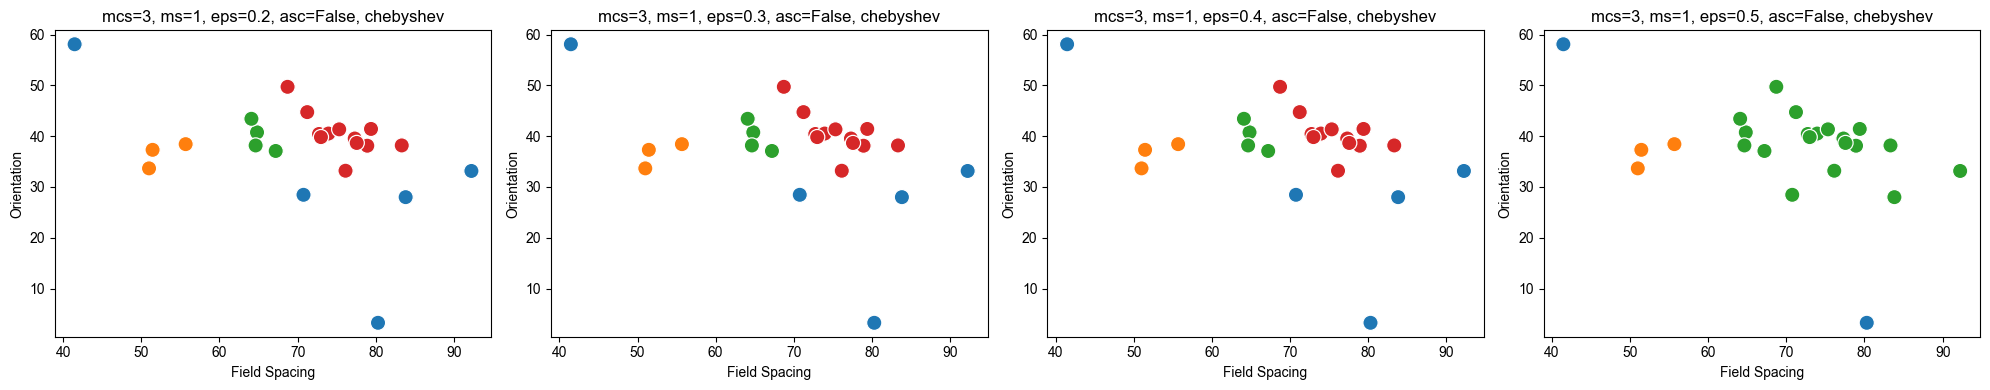

Processing m25d19 with 12 grid cells


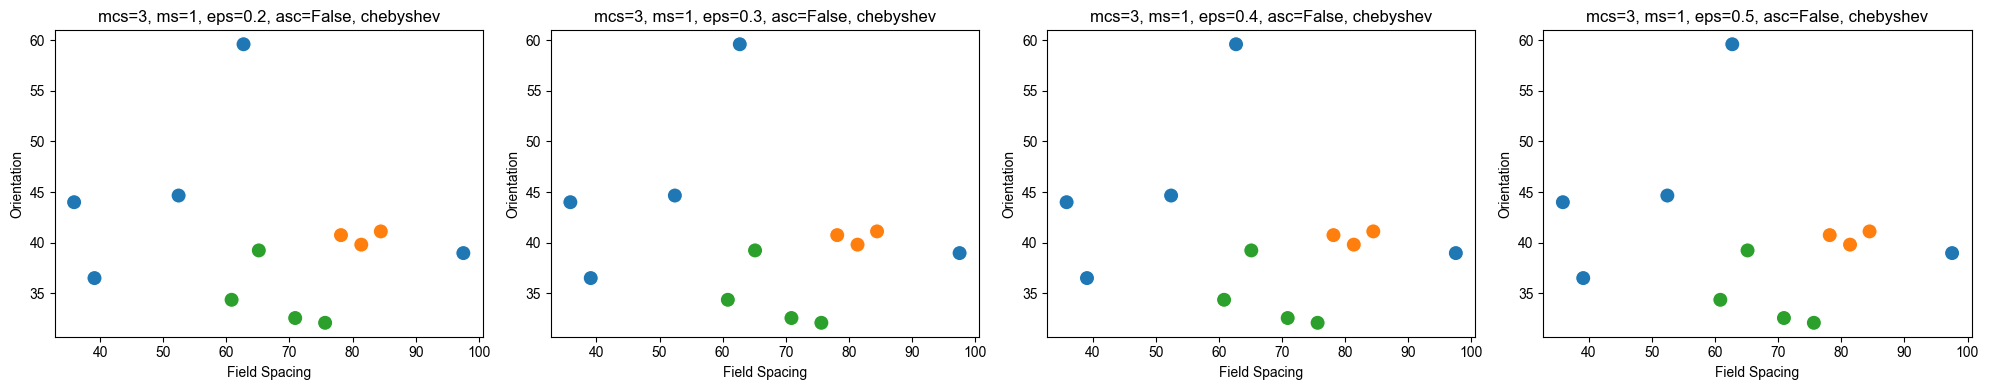

Processing m25d20 with 13 grid cells


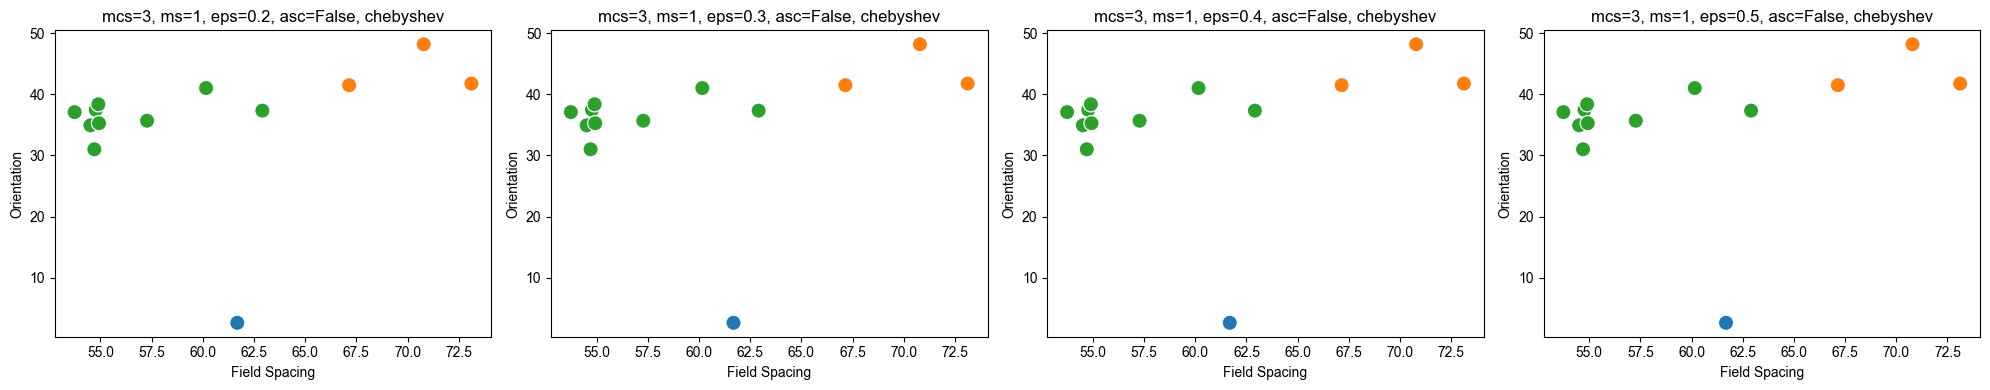

Processing m25d21 with 24 grid cells


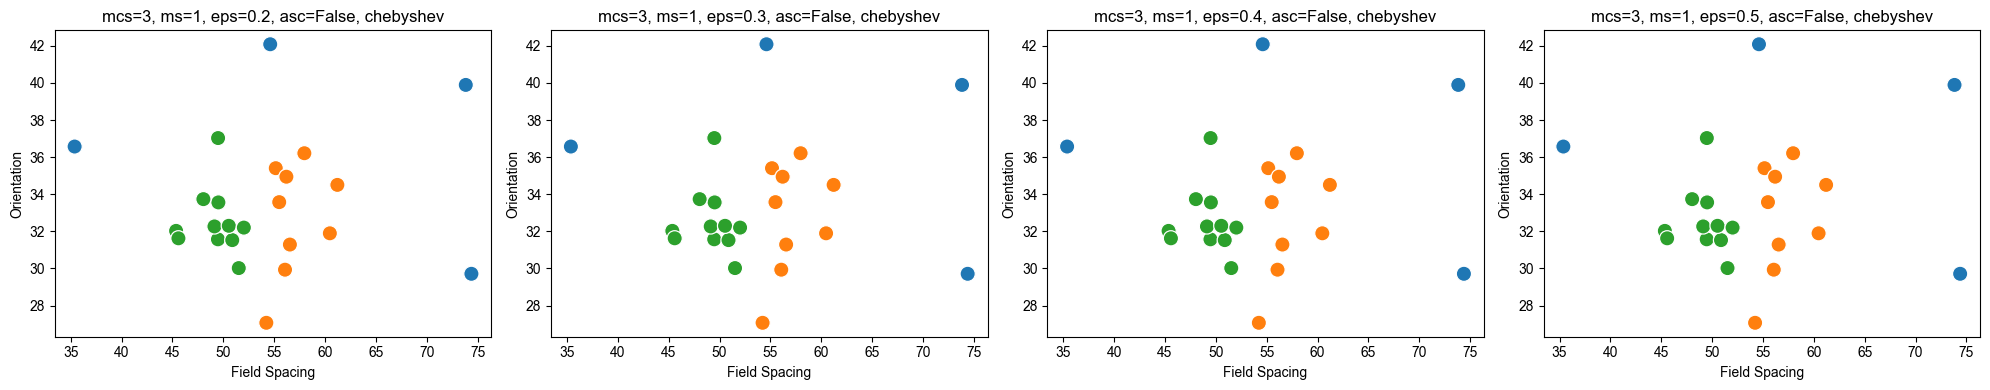

Processing m25d24 with 23 grid cells


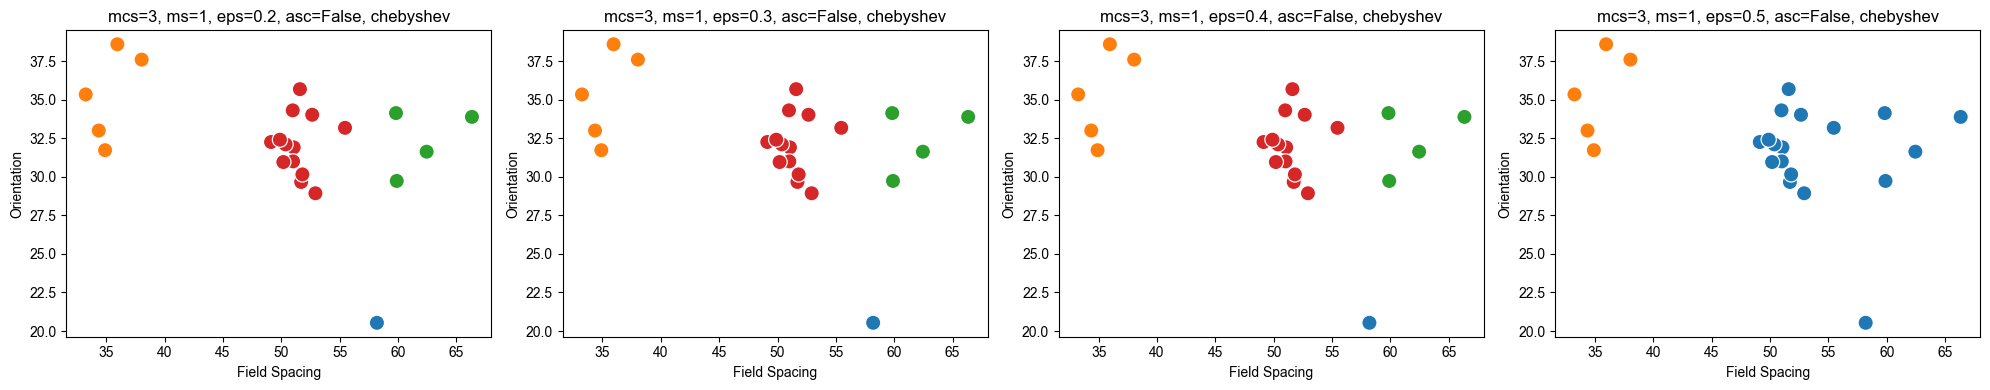

Processing m25d25 with 39 grid cells


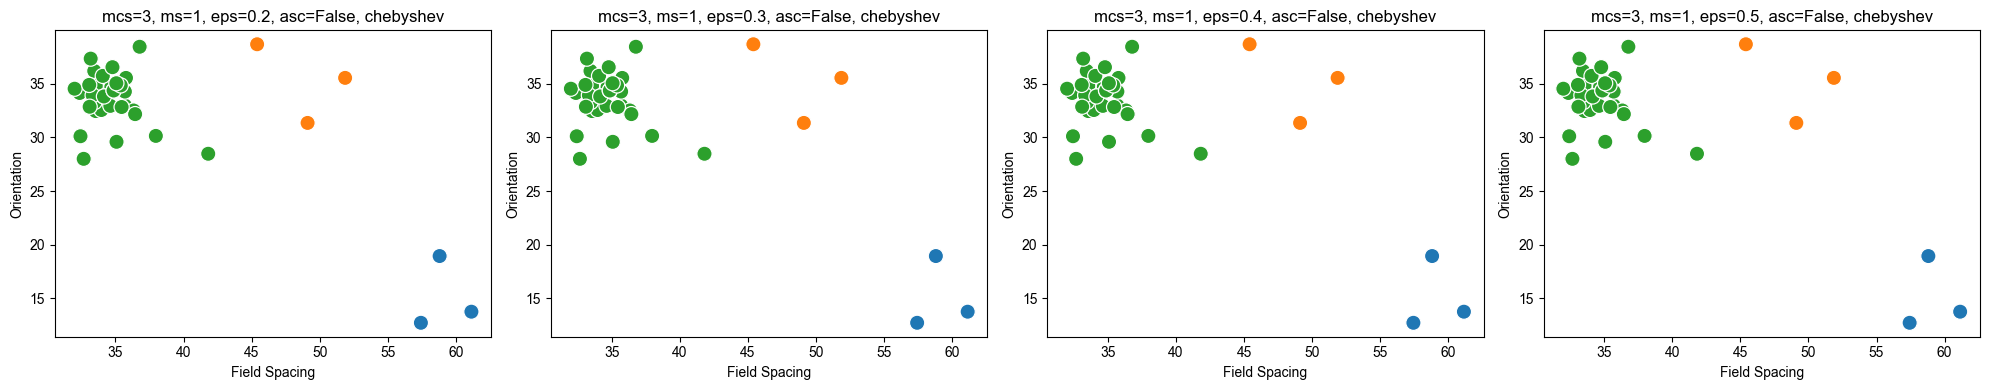

Processing m26d18 with 11 grid cells


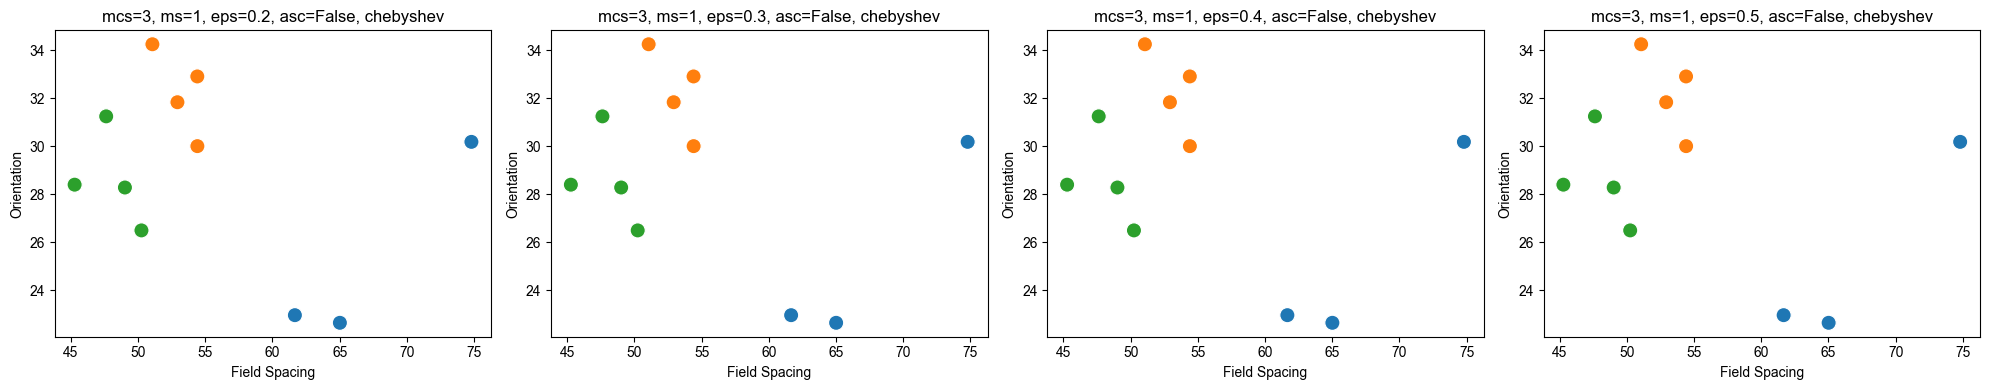

Processing m26d19 with 32 grid cells


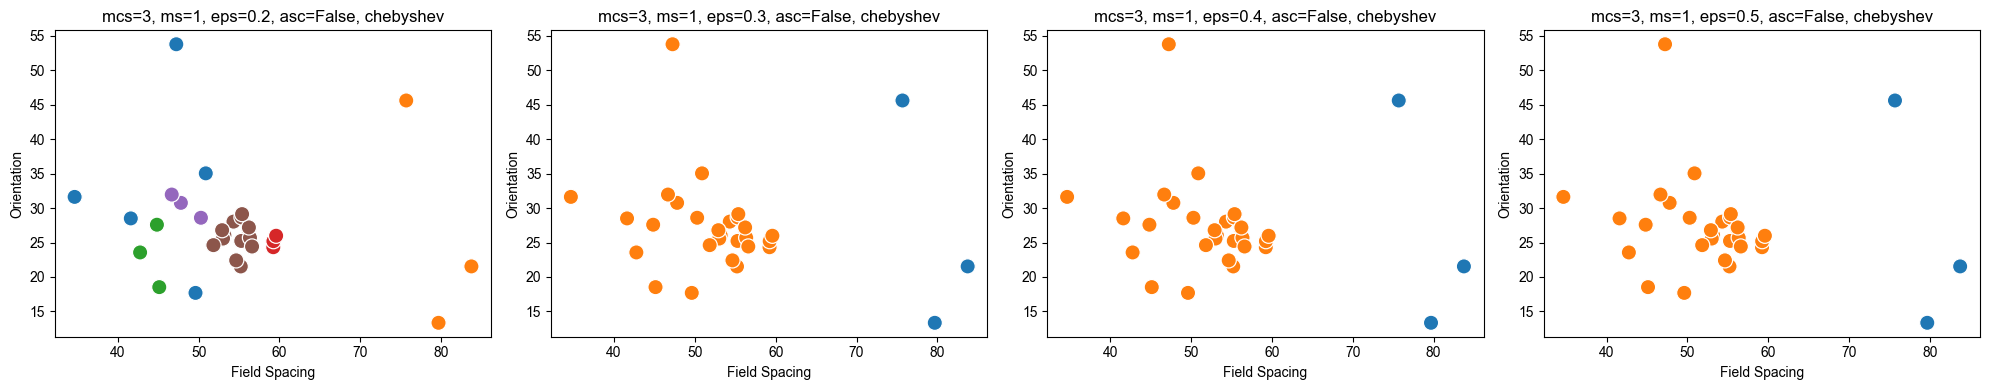

Processing m27d23 with 13 grid cells


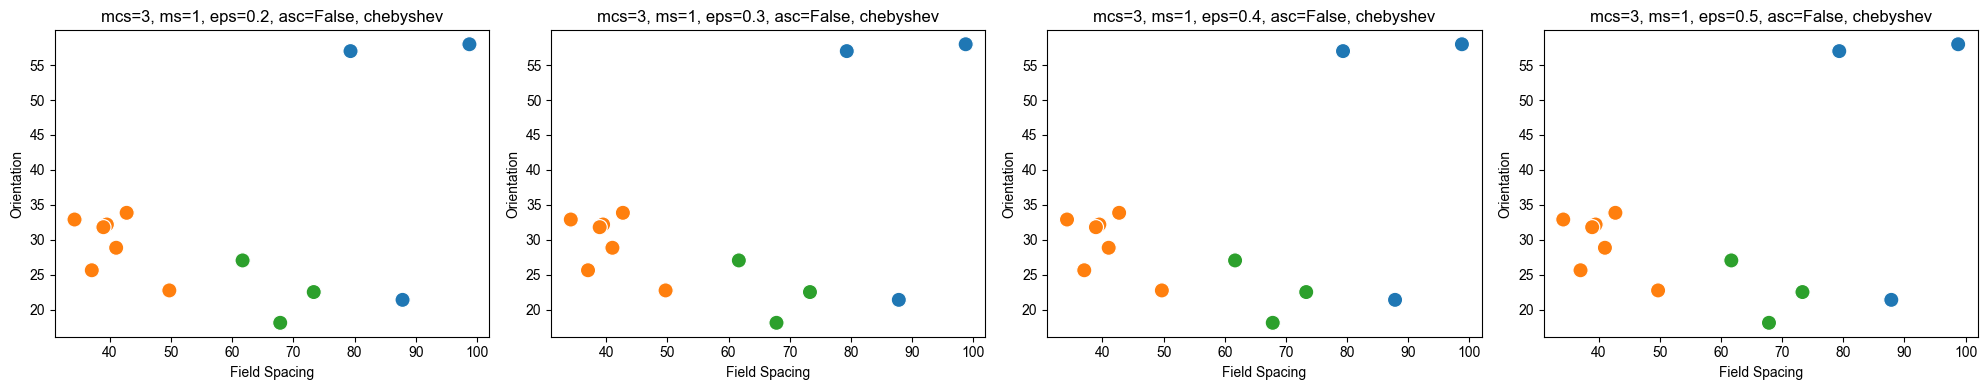

Processing m27d26 with 12 grid cells


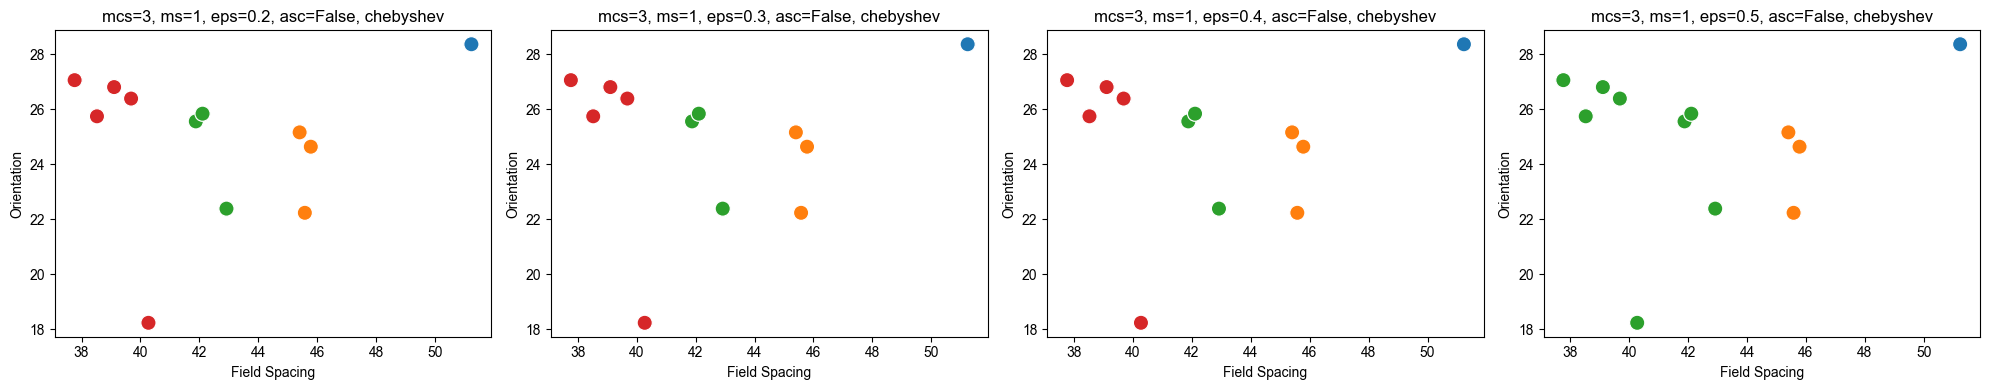

Processing m28d19 with 18 grid cells


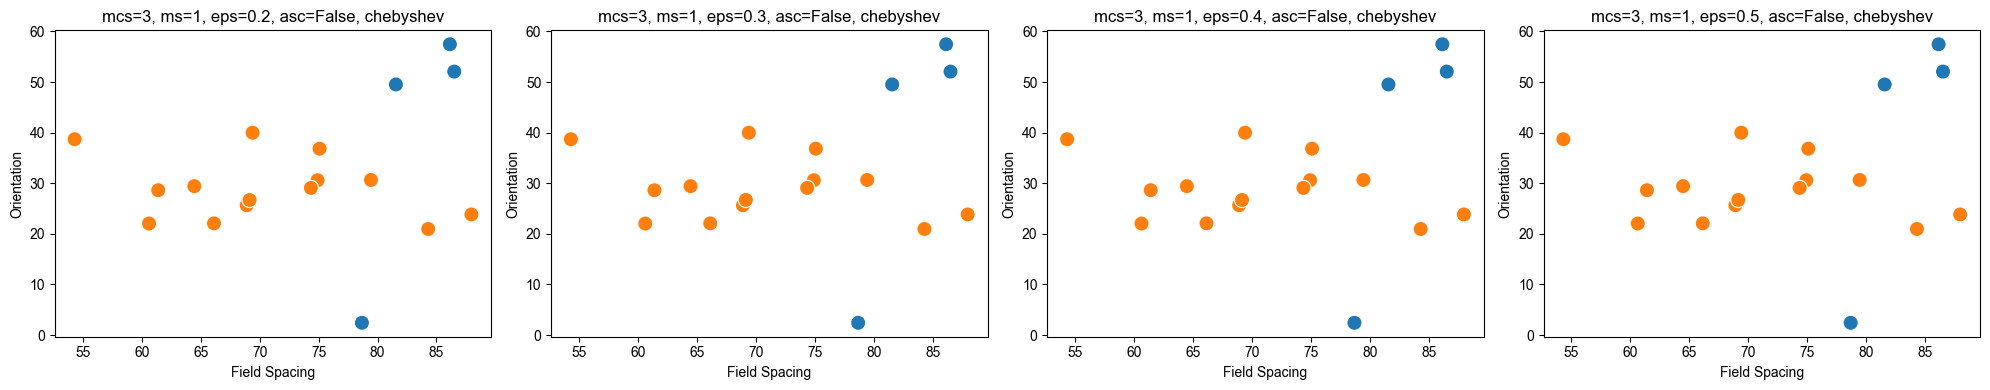

Processing m28d25 with 24 grid cells


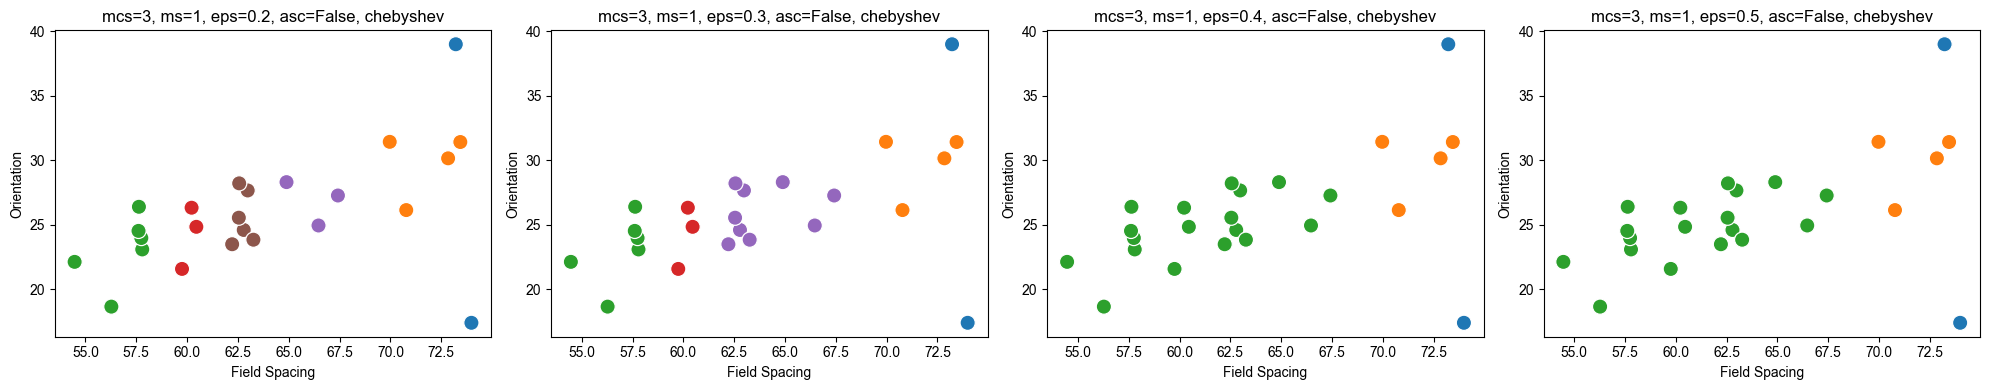

Processing m29d19 with 11 grid cells


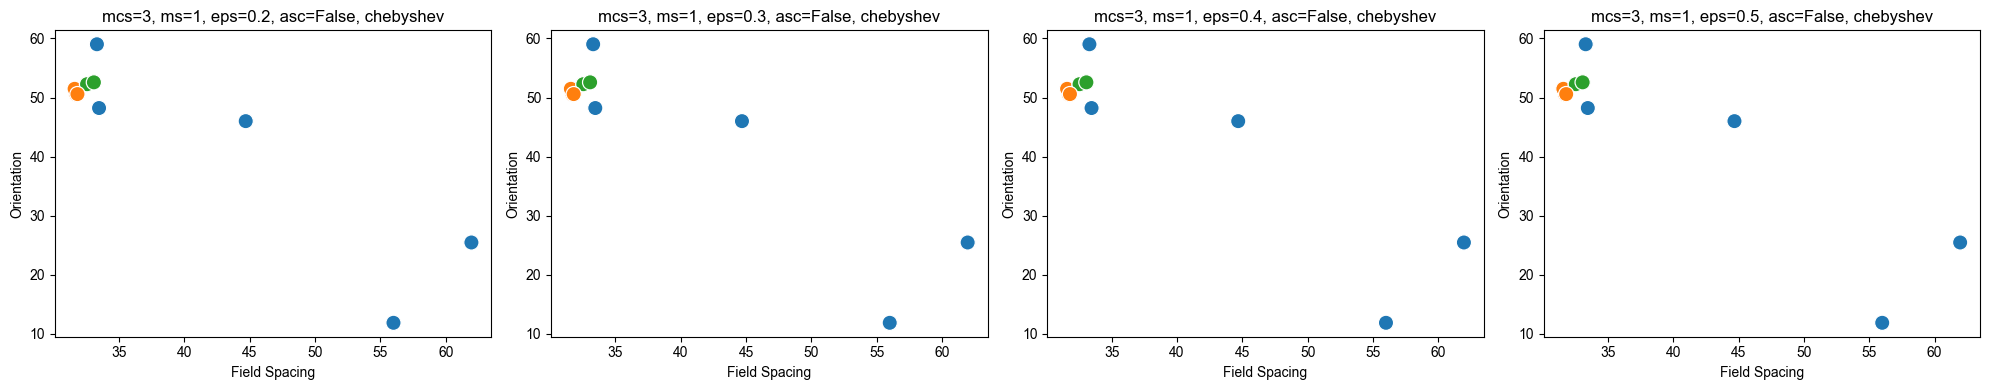

Processing m29d20 with 12 grid cells


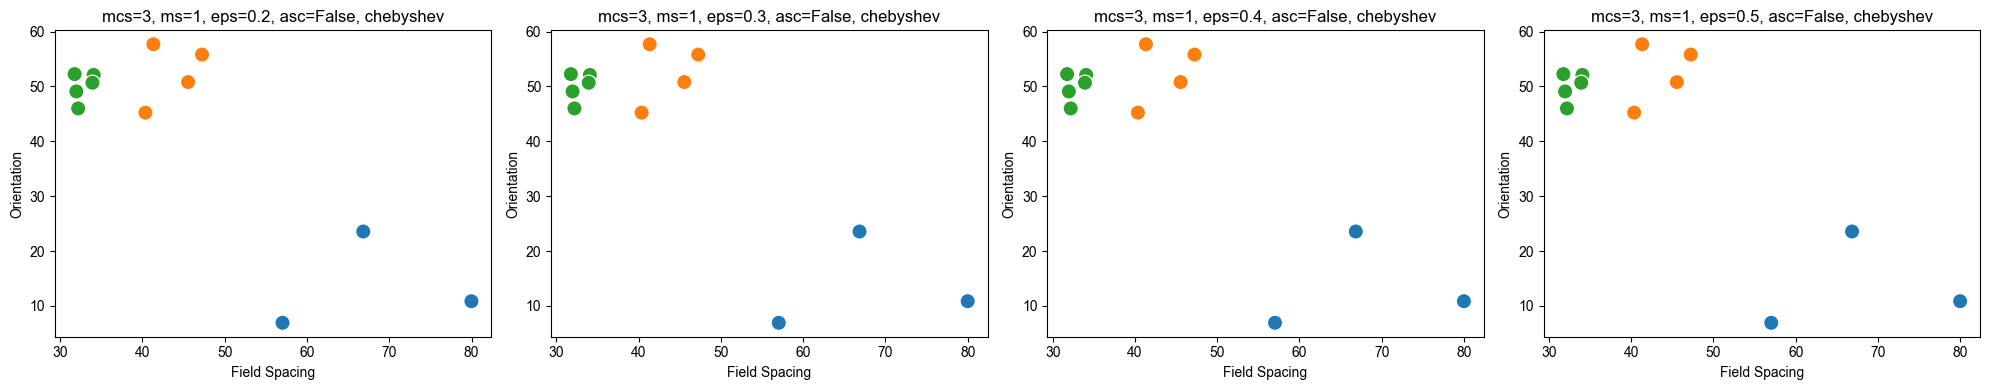

Processing m29d23 with 24 grid cells


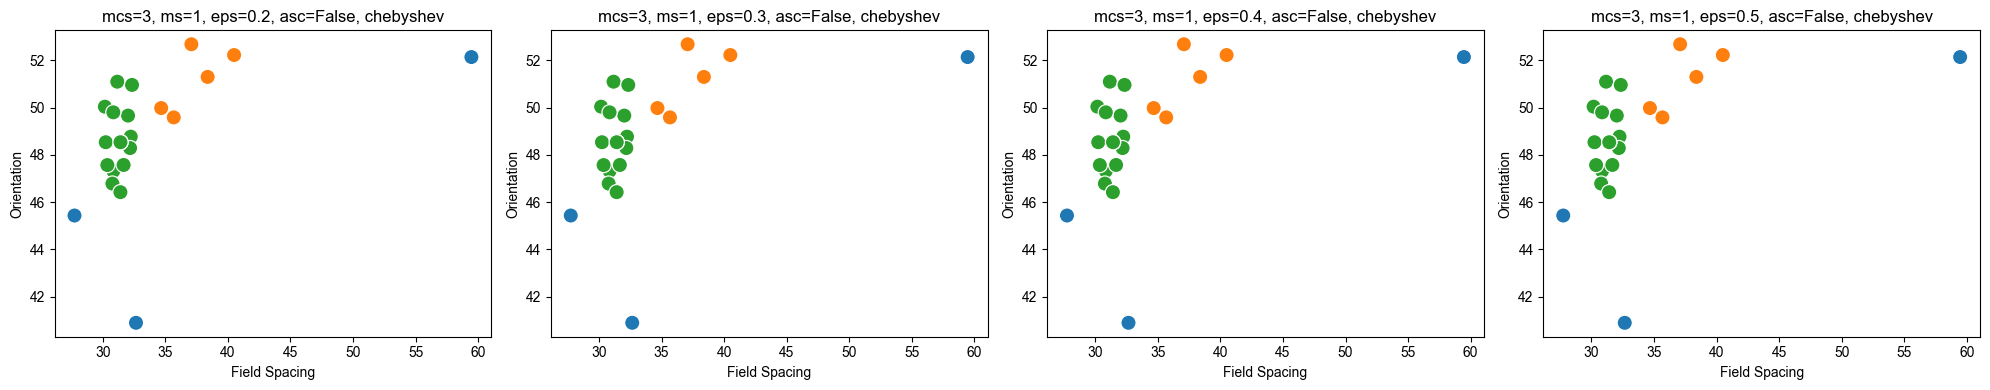

Processing m29d25 with 14 grid cells


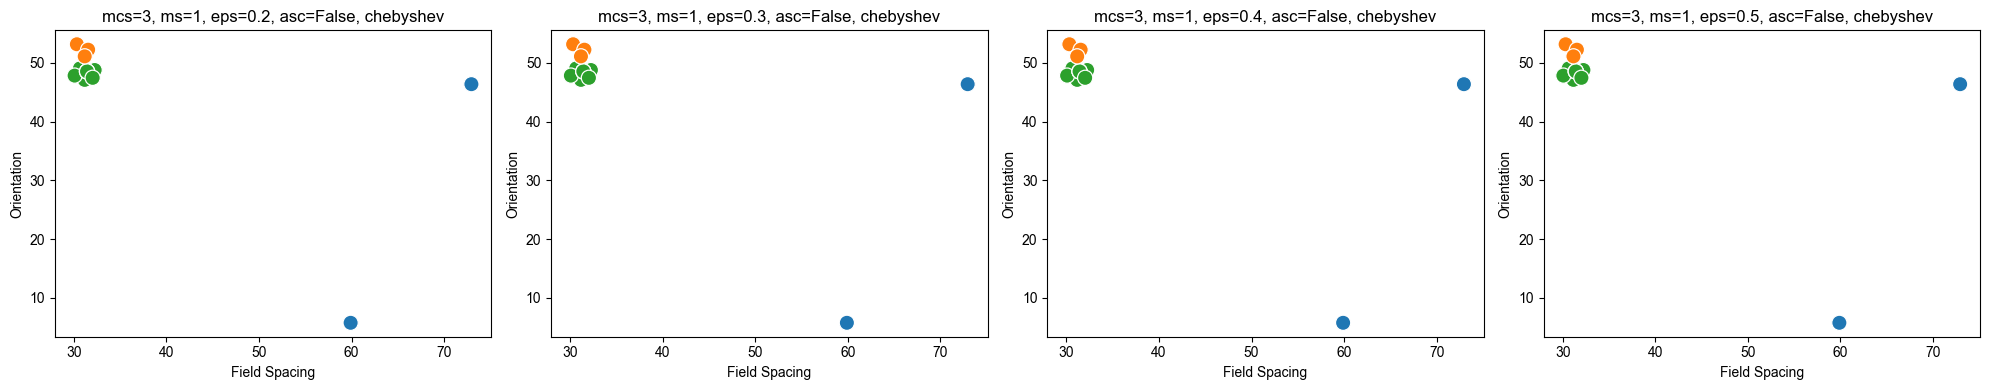

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import hdbscan

for key, df in dict_t.items():
    print(f'Processing {key} with {len(df)} grid cells')
    # Ensure 'field_spacing' and 'orientation' are numeric
    df['field_spacing'] = pd.to_numeric(df['field_spacing'], errors='coerce')
    df['orientation'] = pd.to_numeric(df['orientation'], errors='coerce')
    df.dropna(subset=['field_spacing', 'orientation'], inplace=True)

    # Extract and preprocess features
    X = df[["field_spacing", "orientation"]].copy()

    # Standard scale the 'field_spacing'
    scaler = StandardScaler()
    X["field_spacing_scaled"] = scaler.fit_transform(X[["field_spacing"]])

    # Cyclic encoding for 'orientation' (range 0 to 60)
    X["orientation_sin"] = np.sin(2 * np.pi * X["orientation"] / 60)
    X["orientation_cos"] = np.cos(2 * np.pi * X["orientation"] / 60)

    # Scale sine and cosine components to balance feature influence
    scale_factor = 1 / np.sqrt(2)
    X["orientation_sin_scaled"] = X["orientation_sin"] * scale_factor
    X["orientation_cos_scaled"] = X["orientation_cos"] * scale_factor

    # Prepare the feature matrix
    features = X[["field_spacing_scaled", "orientation_sin_scaled", "orientation_cos_scaled"]]

    # Define extended parameter grid
    min_cluster_sizes = [3]
    min_samples_list = [1]
    epsilons = [0.2, 0.3, 0.4, 0.5]
    allow_single_cluster_options = [False]
    metrics = ['chebyshev']

    # Store parameter combinations
    param_grid = []
    for mcs in min_cluster_sizes:
        for ms in min_samples_list:
            for eps in epsilons:
                for asc in allow_single_cluster_options:
                    for metric in metrics:
                        param_grid.append((mcs, ms, eps, asc, metric))

    # Display limit for subplots
    n_plots = len(param_grid)
    n_cols = 4
    n_rows = int(np.ceil(n_plots / n_cols))

    # Plot clustering results
    plt.figure(figsize=(5 * n_cols, 4 * n_rows))
    for idx, (mcs, ms, eps, asc, metric) in enumerate(param_grid, 1):
        try:
            clusterer = hdbscan.HDBSCAN(
                min_cluster_size=mcs,
                min_samples=ms,
                cluster_selection_epsilon=eps,
                allow_single_cluster=asc,
                metric=metric
            )
            labels = clusterer.fit_predict(features)
            X["cluster"] = labels

            plt.subplot(n_rows, n_cols, idx)
            sns.scatterplot(data=X, x="field_spacing", y="orientation", hue="cluster", palette="tab10", s=120, legend=False)
            plt.title(f"mcs={mcs}, ms={ms}, eps={eps}, asc={asc}, {metric}")
            plt.xlabel("Field Spacing")
            plt.ylabel("Orientation")
        except Exception as e:
            print(f"Failed for params: mcs={mcs}, ms={ms}, eps={eps}, asc={asc}, metric={metric} with error: {e}")

    plt.tight_layout()
    plt.show()


from this it looks like the 2nd column has the best clustering
This is mcs = 3, ms =1, eps=0.3, asc=False and method is chebyshev

In [28]:
clusterer = hdbscan.HDBSCAN(
                min_cluster_size=3,
                min_samples=1,
                cluster_selection_epsilon=0.3,
                allow_single_cluster=False,
                metric='chebyshev'
            )

test it in the function that we'll use for all of the analysis

there are this many clusters before curation 345
last_ephys_bin 21800
last_ephys_time_bin 1807.255
25 25
there are 92 non_grid and non_spatial_cells
there are 39 grid_cells
there are 78 non grid spatial cells
there are 14 non spatial cells
there are 21 speed cells
there are 152 cells
for mi0, there are 3 points
for mi1, there are 3 points
for mi2, there are 33 points


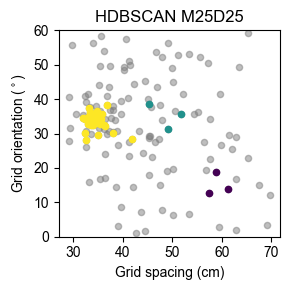

for module 0, there are 3 cells with average spacing 59.12650752692819
for module 1, there are 3 cells with average spacing 48.79472288460559
for module 2, there are 33 cells with average spacing 34.66376365589035
there are this many clusters before curation 345
last_ephys_bin 21800
last_ephys_time_bin 1807.255
module 2 contains cells from ['VISp2/3' 'VISpl2/3' 'VISpl4' 'VISpl5']
module 1 contains cells from ['VISpl2/3' 'VISpl4' 'VISpl5']
module 0 contains cells from ['VISpl5']


In [37]:
mouse=25; day=25
gcs, ngs, ns, sc, ngs_ns, all = cell_classification_of1(mouse, day, percentile_threshold=95) # subset
_,_ = HDBSCAN_grid_modules(gcs, all, mouse=mouse, day=day, figpath='', curate_with_vr=True, curate_with_brain_region=True)